# Alzheimer's Disease and Healthy Aging

In [77]:
# Import libraries
# Plotting and dataframe
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Machine learning
from sklearn.preprocessing import MinMaxScaler

In [78]:
# Import data
df = pd.read_csv("alzheimers_disease_data.csv")
df.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   2149 non-null   int64

Since the relevant categorical variables (gender, ethnicity, education level etc.) are already encoded as integers, we will not have to perform One Hot Encoding on these columns.

In [80]:
# Checking for null values
df.isna().sum()

PatientID                    0
Age                          0
Gender                       0
Ethnicity                    0
EducationLevel               0
BMI                          0
Smoking                      0
AlcoholConsumption           0
PhysicalActivity             0
DietQuality                  0
SleepQuality                 0
FamilyHistoryAlzheimers      0
CardiovascularDisease        0
Diabetes                     0
Depression                   0
HeadInjury                   0
Hypertension                 0
SystolicBP                   0
DiastolicBP                  0
CholesterolTotal             0
CholesterolLDL               0
CholesterolHDL               0
CholesterolTriglycerides     0
MMSE                         0
FunctionalAssessment         0
MemoryComplaints             0
BehavioralProblems           0
ADL                          0
Confusion                    0
Disorientation               0
PersonalityChanges           0
DifficultyCompletingTasks    0
Forgetfu

# Data Cleaning

### Dropped columns
* __PatientID__ (Doesn't tell us anything useful)
* __DoctorInCharge__ (Confidential and doesn't tell us anything useful)

### Null Values
* There are luckily no null values so we will not have to perform any imputing

### Handling Categorical and Numerical Features
* 

In [81]:
df.drop(columns=['PatientID', 'DoctorInCharge'], inplace=True)

df.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,6.045039,0,0,0.014691,0,0,1,1,0,0


In [82]:
# Checking for duplicates
df.duplicated().sum()

0

In [83]:
# To make it easier, I changed 'Diagnosis' to 'target'
df.rename(columns={'Diagnosis': 'target'}, inplace=True)

df.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,target
0,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,6.045039,0,0,0.014691,0,0,1,1,0,0


# Feature Engineering

1. Health Score
    - This metric is a combination of health measures into one score. A higher health score indicates better overall health
    - The weights assigned were calculated using Feature Importance from a random forest model, which shows the specific weights assigned to each attribute that is related to health.
2. Count of Health Issues
    - Combining __FamilyHistoryAlzheimers__, __CardiovascularDisease__, __Diabetes__, __Depression__, __HeadInjury__, __Hypertension__ into a count of health issues according to medical history
3. Education + Ethnicity
    - Highlights the interaction between the two variables.
        - 0_0 represents a Caucasian with no education
        - 0_1 represents a Caucasian with a high school diploma
        - 0_2 represents a Caucasian with a bachelor's degree
        - 0_3 represents a Caucasian with an advanced degree
        - The same applies for 1_X (African American), 2_X (Asian), or 3_X (Other)

In [94]:
from sklearn.ensemble import RandomForestClassifier

# Define health-related features
health_columns = ['BMI', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'Smoking', 'AlcoholConsumption']

# Define the features (X) and target (y)
X = df[health_columns]
y = df['target']

# Fit the Random Forest model
rf = RandomForestClassifier()
rf.fit(X, y)

# Get the feature importances (weights)
importances = rf.feature_importances_

# Display the weights for each health attribute
weights_df = pd.DataFrame({'HealthAttribute': health_columns, 'Weight': importances})
print(weights_df)


      HealthAttribute    Weight
0                 BMI  0.191576
1    PhysicalActivity  0.191353
2         DietQuality  0.199188
3        SleepQuality  0.202912
4             Smoking  0.022713
5  AlcoholConsumption  0.192259


In [86]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate the scaler
scaler = MinMaxScaler()

# Reverse the 'Smoking' column values (1 is YES, 0 is NO)
df['Smoking'] = 1 - df['Smoking']

# Transform 'AlcoholConsumption' to reflect lower consumption as better health
df['AlcoholConsumption'] = 1 - scaler.fit_transform(df[['AlcoholConsumption']])


# Health columns and their weights
health_columns = {
    'BMI': 0.191576,
    'PhysicalActivity': 0.191353,
    'DietQuality': 0.199188,
    'SleepQuality': 0.202912,
    'Smoking': 0.022713,
    'AlcoholConsumption': 0.192259
}

# Normalize the health columns
for col in health_columns:
    df[[col]] = scaler.fit_transform(df[[col]])

# Calculate weighted health score
df['HealthScore'] = sum(weight * df[col] for col, weight in health_columns.items())

# Cardiometabolic columns
cardiometabolic_columns = {
    'SystolicBP': 0.2,
    'CholesterolTotal': 0.2,
    'CholesterolLDL': 0.2,
    'CholesterolHDL': 0.2,
    'CholesterolTriglycerides': 0.2
}

# Normalize the cardiometabolic columns
for col in cardiometabolic_columns:
    df[[col]] = scaler.fit_transform(df[[col]])

# Invert 'CholesterolLDL' to reflect higher values as worse health
df['CholesterolLDL'] = 1 - df['CholesterolLDL']

# Calculate Cardiometabolic Index as a weighted sum
df['CardiometabolicIndex'] = sum(weight * df[col] for col, weight in cardiometabolic_columns.items())

# Normalize the Cardiometabolic Index
df[['CardiometabolicIndex']] = scaler.fit_transform(df[['CardiometabolicIndex']])

# Combine HealthScore and normalized CardiometabolicIndex to create final HealthScore
df['TotalHealthScore'] = df['HealthScore'] + df['CardiometabolicIndex']

# Display the final DataFrame
df.head()


,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,target,HealthScore,CardiometabolicIndex,TotalHealthScore
0,73,0,0,2,0.316960,1.0,0.334817,0.633375,0.133931,0.837564,...,1.725883,0,0,0,1,0,0,0.517848,0.546996,1.064844
1,89,0,0,0,0.473058,1.0,0.772830,0.762862,0.050995,0.525021,...,2.592424,0,0,0,0,1,0,0.539670,0.460269,0.999939
2,73,0,3,1,0.111553,1.0,0.021724,0.785408,0.181896,0.945597,...,7.119548,0,1,0,1,0,0,0.507063,0.391226,0.898289
3,74,1,0,1,0.752163,0.0,0.389249,0.843804,0.743443,0.731994,...,6.481226,0,0,0,0,0,0,0.653206,0.517528,1.170734
4,89,0,0,0,0.228472,1.0,0.076796,0.631707,0.078698,0.265892,...,0.014691,0,0,1,1,0,0,0.348633,0.507902,0.856536


In [87]:
# Creating count of health issues
health_issues_columns = ['FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension']
df['NumHealthIssues'] = df[health_issues_columns].sum(axis=1)

In [88]:
# Creating Education + Ethnicity
df['EducationEthnicity'] = df['Ethnicity'].astype(str) + "_" + df['EducationLevel'].astype(str)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        2149 non-null   int64  
 1   Gender                     2149 non-null   int64  
 2   Ethnicity                  2149 non-null   int64  
 3   EducationLevel             2149 non-null   int64  
 4   BMI                        2149 non-null   float64
 5   Smoking                    2149 non-null   float64
 6   AlcoholConsumption         2149 non-null   float64
 7   PhysicalActivity           2149 non-null   float64
 8   DietQuality                2149 non-null   float64
 9   SleepQuality               2149 non-null   float64
 10  FamilyHistoryAlzheimers    2149 non-null   int64  
 11  CardiovascularDisease      2149 non-null   int64  
 12  Diabetes                   2149 non-null   int64  
 13  Depression                 2149 non-null   int64

# Exploratory Data Analysis

In [90]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,2149.0,74.908795,8.990221,6.000000e+01,67.000000,75.000000,83.000000,90.000000
Gender,2149.0,0.506282,0.500077,0.000000e+00,0.000000,1.000000,1.000000,1.000000
Ethnicity,2149.0,0.697534,0.996128,0.000000e+00,0.000000,0.000000,1.000000,3.000000
EducationLevel,2149.0,1.286645,0.904527,0.000000e+00,1.000000,1.000000,2.000000,3.000000
BMI,2149.0,0.506199,0.288883,0.000000e+00,0.264272,0.512933,0.754923,1.000000
Smoking,2149.0,0.711494,0.453173,0.000000e+00,0.000000,1.000000,1.000000,1.000000
AlcoholConsumption,2149.0,0.497809,0.288079,0.000000e+00,0.241722,0.503064,0.742946,1.000000
PhysicalActivity,2149.0,0.492456,0.286182,0.000000e+00,0.257117,0.477053,0.743632,1.000000
DietQuality,2149.0,0.498926,0.291227,0.000000e+00,0.245178,0.507230,0.755758,1.000000
SleepQuality,2149.0,0.508312,0.294065,0.000000e+00,0.246843,0.519077,0.760335,1.000000


Takeaways:
- The people in this dataset, on average, are less educated (1.2)
- There are more smokers in this dataset (0.71)
- Physical activity, diet quality, and sleep quality are generally average, at around 0.5
- Most of the data points in this dataset have no Alzheimer's diagnosis (around 65%)

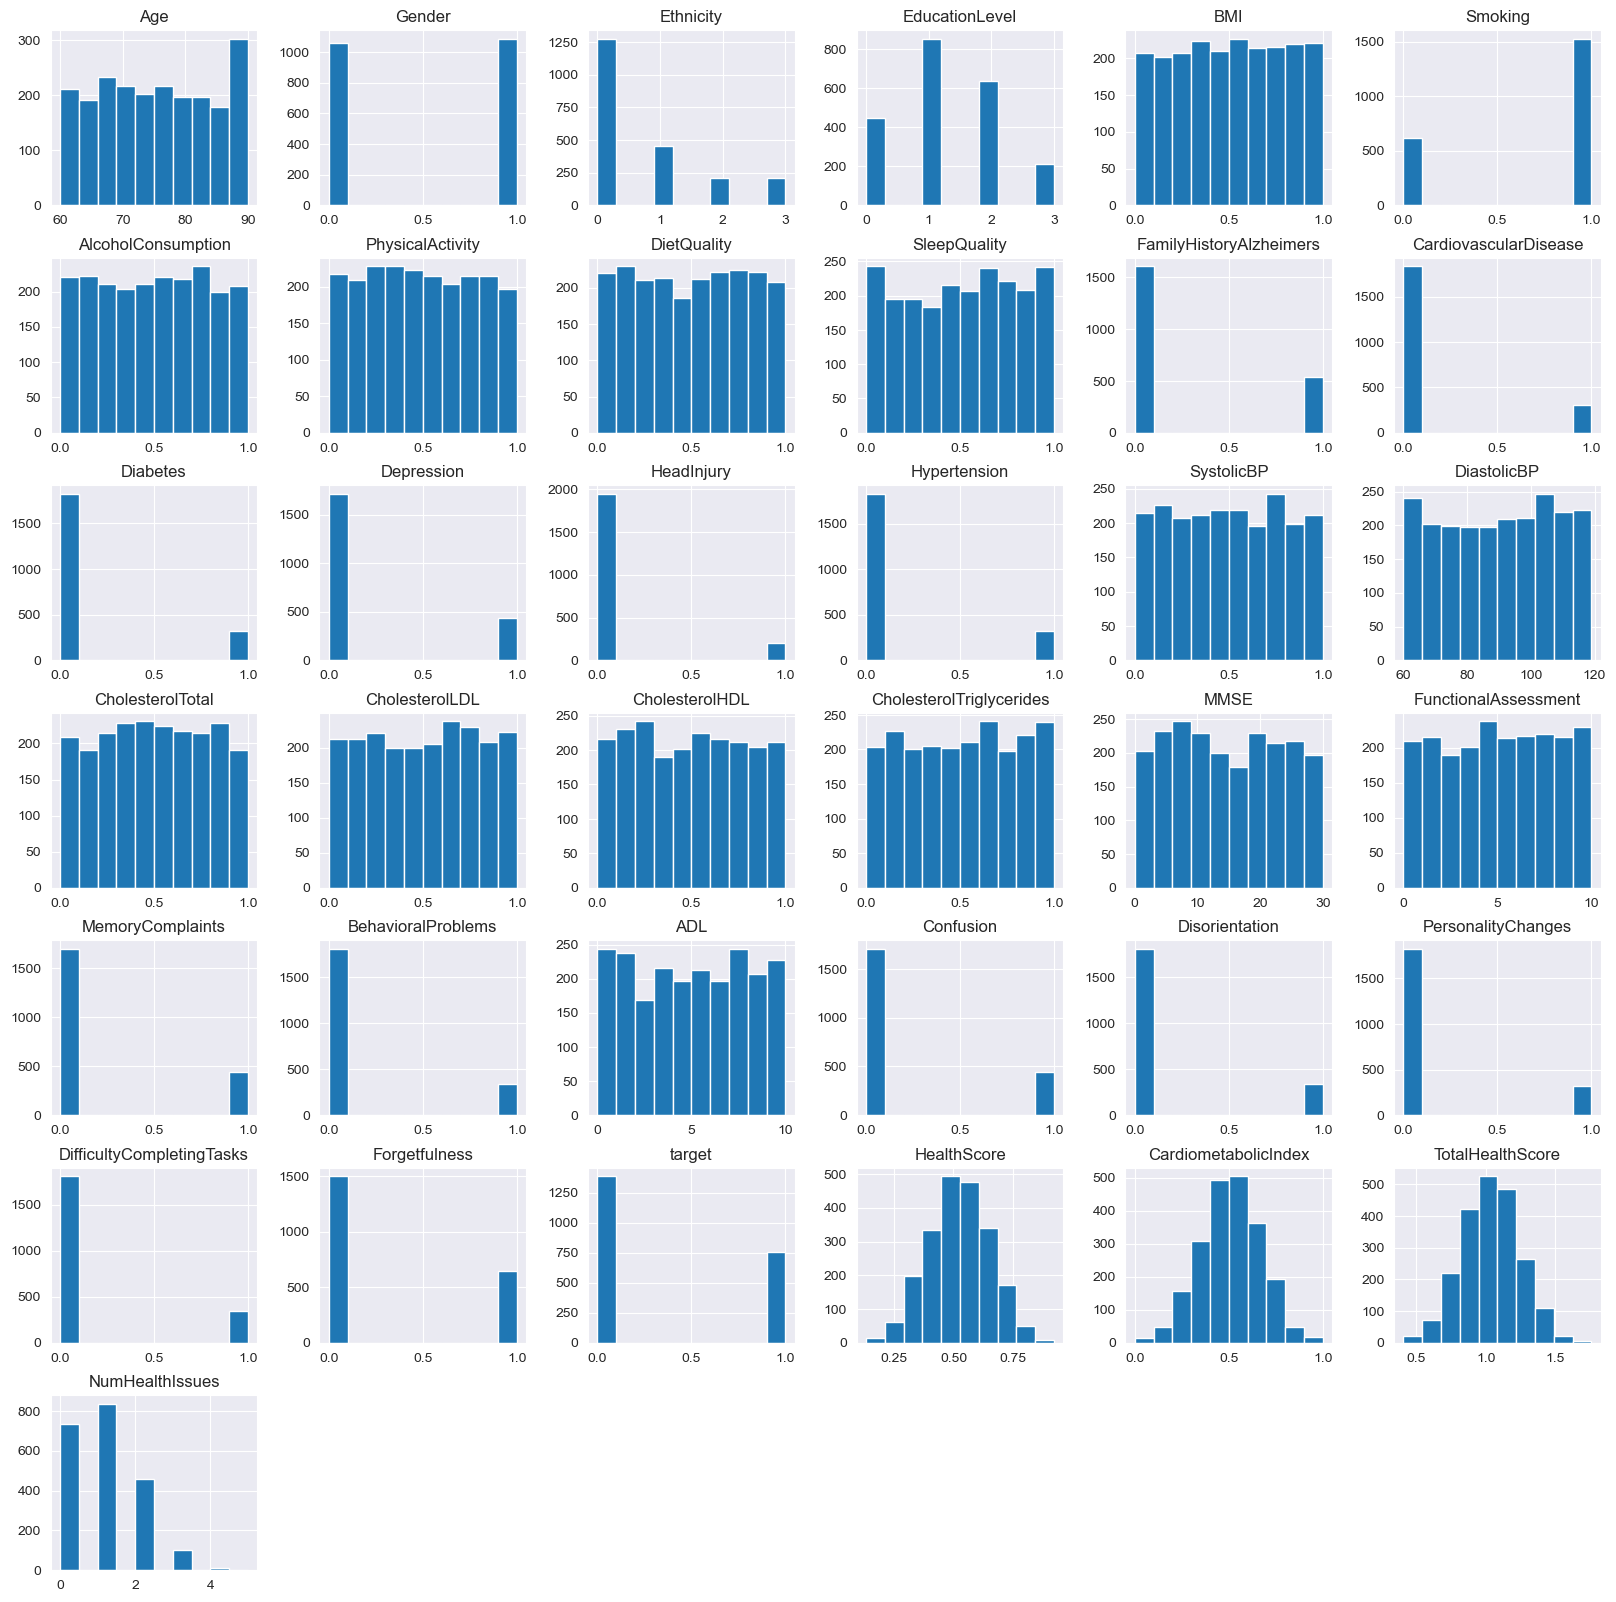

In [91]:
df.hist(figsize=(20,20))
plt.show()

Let's take a look at correlations now

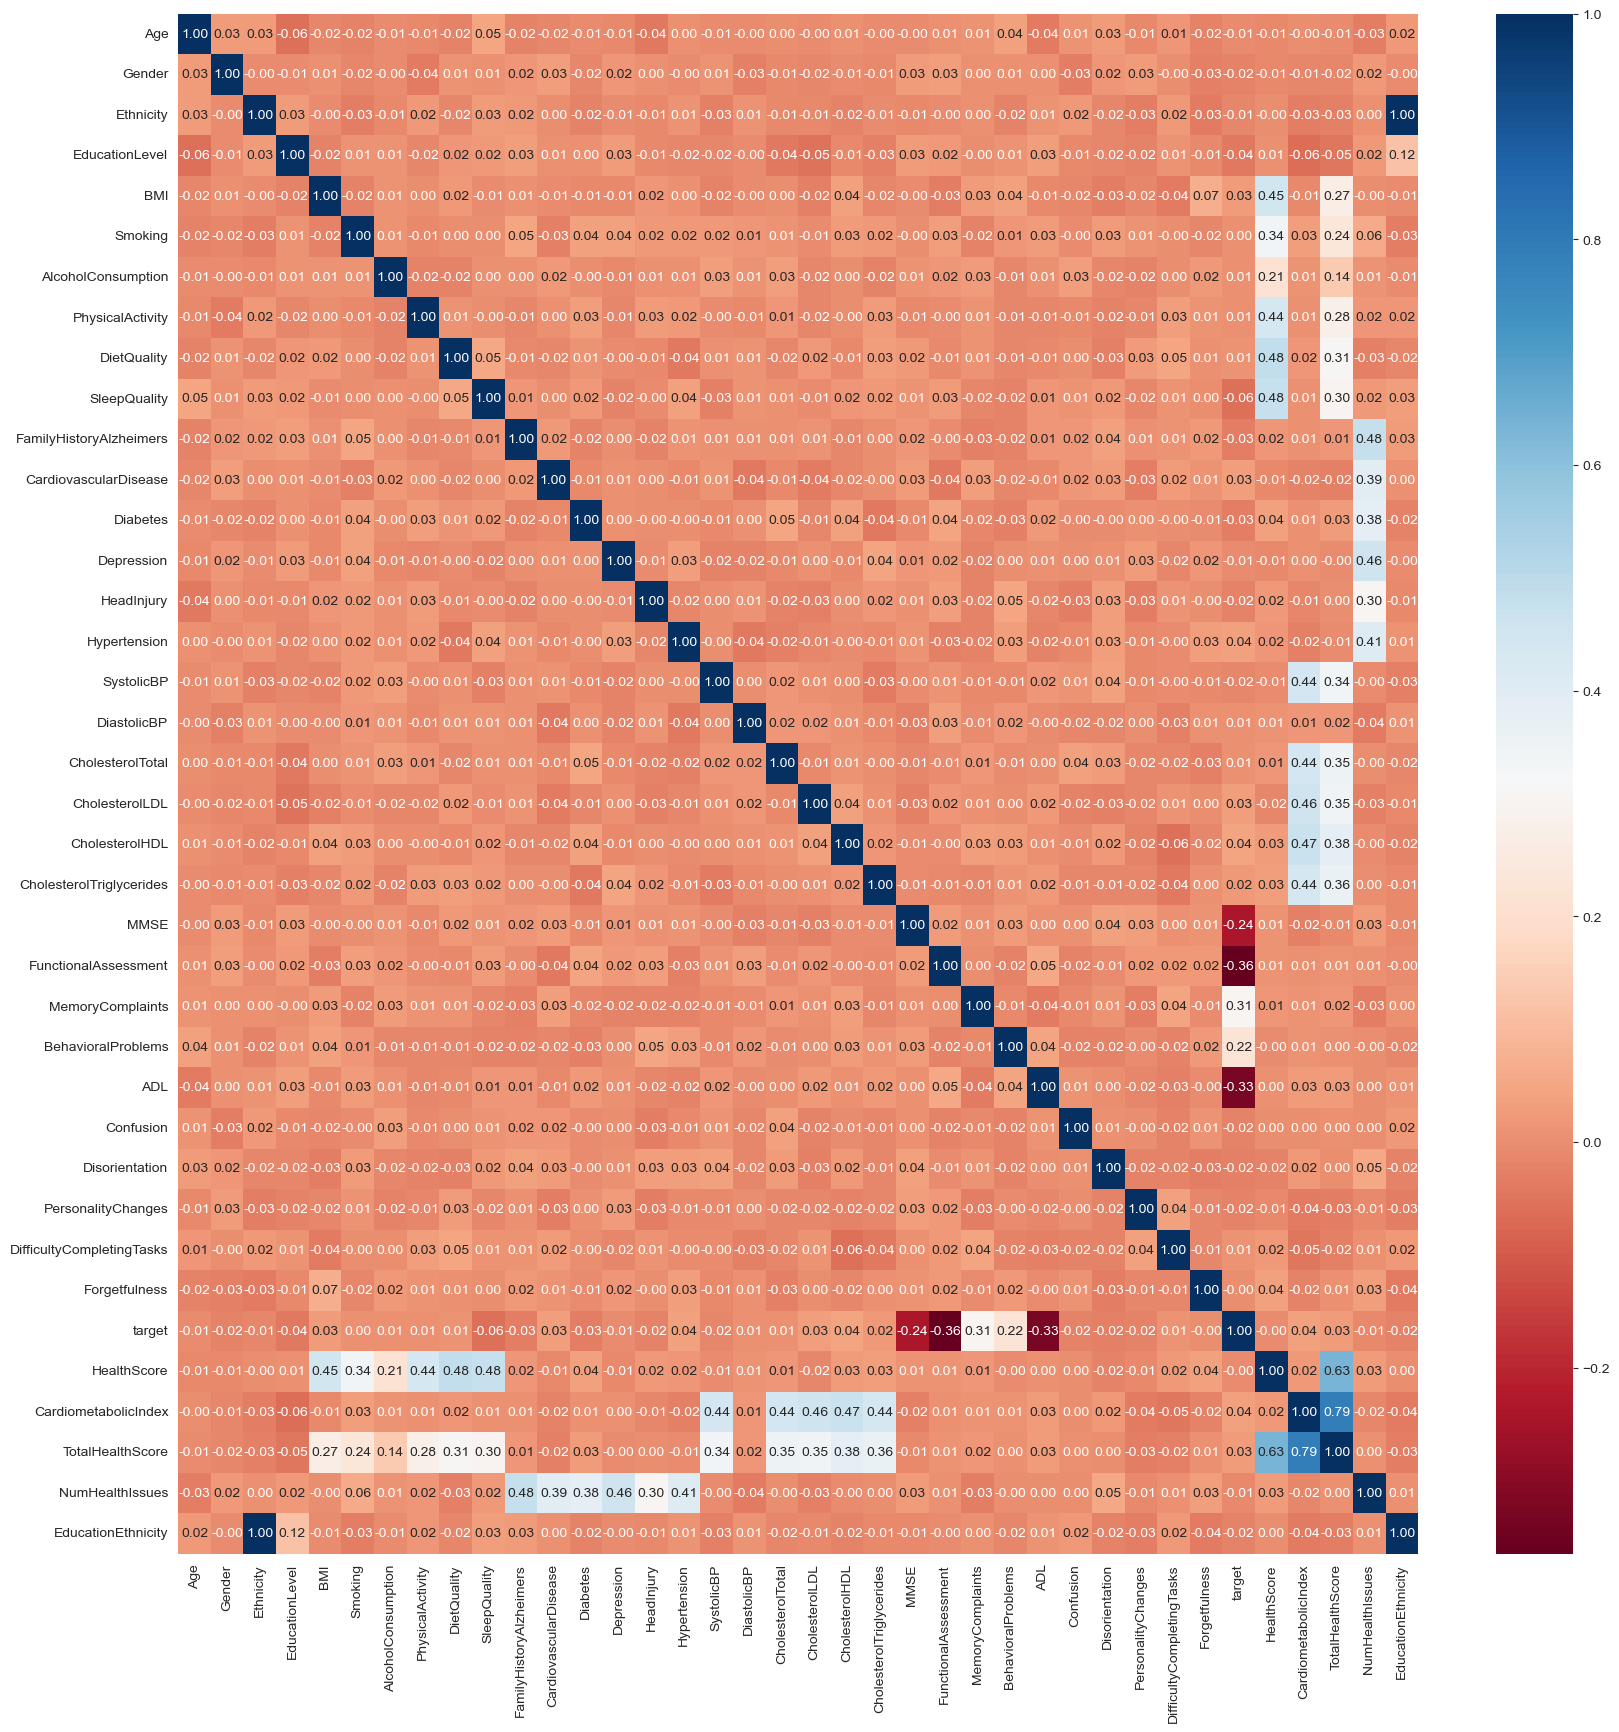

In [92]:
# Creating correlation matrix
correlations = df.corr()

plt.figure(figsize=(20,20))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='RdBu')
plt.show()

There are some interesting correlation patterns that are seen in this matrix, specifically:
- HealthScore and Smoking seem to be positively correlated (in this instance, this makes sense since a higher smoking score means less smoking), meaning Non-Smoker tend to have a higher HealthScore
- MemoryComplaints and target seem to be moderately positively correlated
- target and a history of Alzheimer's in the family seems to be not correlated at all, which is very interesting. There is emerging research that suggests there is some level of genetic factors in developing Alzheimer's, one such being the APOE 4 gene which can increase the probability of someone developing the disease 2-10 times

In [93]:
# looking at correlation with target more closely
correlations['target'].sort_values(ascending=False)

target                       1.000000
MemoryComplaints             0.306742
BehavioralProblems           0.224350
CholesterolHDL               0.042584
CardiometabolicIndex         0.038982
Hypertension                 0.035080
CholesterolLDL               0.031976
CardiovascularDisease        0.031490
TotalHealthScore             0.027660
BMI                          0.026343
CholesterolTriglycerides     0.022672
DifficultyCompletingTasks    0.009069
DietQuality                  0.008506
AlcoholConsumption           0.007618
CholesterolTotal             0.006394
PhysicalActivity             0.005945
DiastolicBP                  0.005293
Smoking                      0.004865
Forgetfulness               -0.000354
HealthScore                 -0.004094
Age                         -0.005488
Depression                  -0.005893
NumHealthIssues             -0.011744
Ethnicity                   -0.014782
SystolicBP                  -0.015615
EducationEthnicity          -0.018653
Confusion   